# Grey-box identification of heat transfer dynamics

Last update: 27-07-2023

---

The primary goal of this project is to identify convection effects in a grey-box model of heat transfer dynamics (see system description below), based on temperature measurements throughout the rod.

In [1]:
import Pkg
Pkg.activate("..")
Pkg.instantiate()

  Activating project at `~/syndr/Wouter/Onderzoek/Projecten/sioux/sysid-thermal/CCTA2024-BIDconvection`


┌ Warning: The active manifest file has dependencies that were resolved with a different julia version (1.10.0). Unexpected behavior may occur.
└ @ nothing /home/wmkouw/syndr/Wouter/Onderzoek/Projecten/sioux/sysid-thermal/CCTA2024-BIDconvection/Manifest.toml:0


In [2]:
Pkg.status()

Status `~/syndr/Wouter/Onderzoek/Projecten/sioux/sysid-thermal/CCTA2024-BIDconvection/Project.toml`
⌃ [0a1fb500] BlockDiagonals v0.1.41
⌃ [0c46a032] DifferentialEquations v7.8.0
⌃ [31c24e10] Distributions v0.25.95
⌃ [f6369f11] ForwardDiff v0.10.35
⌃ [033835bb] JLD2 v0.4.31
⌃ [b964fa9f] LaTeXStrings v1.3.0
⌃ [23992714] MAT v0.10.5
⌃ [429524aa] Optim v1.7.6
⌅ [91a5bcdd] Plots v1.38.15
⌃ [f27b6e38] Polynomials v3.2.13
⌃ [86711068] RxInfer v2.11.1
⌃ [276daf66] SpecialFunctions v2.2.0
⌅ [2913bbd2] StatsBase v0.33.21
  [3a884ed6] UnPack v1.0.2
  [37e2e46d] LinearAlgebra
  [9a3f8284] Random
Info Packages marked with ⌃ and ⌅ have new versions available, but those with ⌅ are restricted by compatibility constraints from upgrading. To see why use `status --outdated`


## System description

A schematic depiction of the setup is shown in the figure below. 

<p><center><img src='../../system/system-photo.png'/></center></p>

In short, the setup consists of 3 metal blocks which have been lined up, with resistive nylon pads interposed. The temperature can be measured using thermistors at arbitrary places on the setup; for simplicity we assume that we measure the temperature at a single spot on each block, which we call $\tau_1$, $\tau_2$, and $\tau_3$. The temperatures will evolve due to a number of different factors; we will only consider the influence of conduction, convection, radiation, and the user controlled input heat (band heaters).

By assuming that conduction within blocks is so fast that there are no temperature differences within a block, we may model the system using a [lumped-element model](https://en.wikipedia.org/wiki/Lumped-element_model), governed by the following system of ODEs:

$$\frac{d}{dt}\begin{pmatrix} m_1 c_{p, 1} \tau_1 \\ m_2 c_{p, 2} \tau_2 \\ m_3 c_{p, 3} \tau_3 \end{pmatrix} = 
\underbrace{\begin{pmatrix} -k_{12} & k_{12} & 0 \\ k_{12} & -(k_{12} + k_{23}) & k_{23} \\ 0 & k_{23} & -k_{23} \end{pmatrix} \begin{pmatrix} \tau_1 \\ \tau_2 \\ \tau_3 \end{pmatrix}}_{\textrm{conduction}} + \underbrace{\begin{pmatrix} h(\tau_1, \tau_a, 1, t) \\ h(\tau_2, \tau_a, 2, t) \\ h(\tau_3, \tau_a, 3, t) \end{pmatrix}}_{\textrm{convection}} + \underbrace{\sigma \begin{pmatrix} a_1 \varepsilon_1 (\tau_a^4 - \tau_1^4) \\ a_2 \varepsilon_2 (\tau_a^4 - \tau_2^4) \\ a_3 \varepsilon_3 (\tau_a^4 - \tau_3^4) \end{pmatrix}}_{\textrm{radiation}} + \underbrace{\begin{pmatrix} u_1 \\ u_2 \\ u_3 \end{pmatrix}}_{\textrm{input}}.$$

Convection is notoriously hard to model. A coarse approximation would be Newton's law of cooling (Clercx, 2015; Eq. 8.17), which states that convection is linear in the difference between the temperature of the block and the ambient temperature: $h_a (\tau_a - \tau_i)$. With this linear term, we can take steps similar to the identification of the oscillator in Rogers \& Friis (2022), describing the nonlinear function as the combination of a linear term and a "nonlinear remainder":

$$\underbrace{h(\tau_i, \tau_a, i, t)}_{\text{total convection}} = \underbrace{h_a (\tau_a - \tau_i)}_{\text{linear cooling law}} + \underbrace{r(\tau_i, \tau_a, i, t)}_{\text{nonlinear remainder}} \, ,$$

for some constant $h_a$. Furthermore, the role of radiation can often be neglected. With these simplifications, our governing equations become:

$$\frac{d}{dt}\begin{pmatrix} m_1 c_{p, 1} \tau_1 \\ m_2 c_{p, 2} \tau_2 \\ m_3 c_{p, 3} \tau_3 \end{pmatrix} = 
\begin{pmatrix} -k_{12} & k_{12} & 0 \\ k_{12} & -(k_{12} + k_{23}) & k_{23} \\ 0 & k_{23} & -k_{23} \end{pmatrix} \begin{pmatrix} \tau_1 \\ \tau_2 \\ \tau_3 \end{pmatrix} + h_a \begin{pmatrix} a_1 (\tau_a - \tau_1) \\ a_2 (\tau_a - \tau_2) \\ a_3 (\tau_a - \tau_3) \end{pmatrix} + \begin{pmatrix} r(\tau_1, \tau_a, 1, t) \\ r(\tau_2, \tau_a, 2, t) \\ r(\tau_3, \tau_a, 3, t) \end{pmatrix} + \begin{pmatrix} u_1 \\ u_2 \\ u_3 \end{pmatrix},$$

or, more compactly, 

$$ M \dot{z} = K z + h_a a (\tau_a - z) + r(z,\tau_a) + u$$

where $z = [\tau_1 \, , \ \tau_2 \, , \ \tau_3]$.

In these equations, we can distinguish three types of quantities:
1. Measured/observed quantities: e.g. $\tau_i$, $u_i$. These may vary over time, and are known up to a given accuracy due to measurement noise;

2. Known constants: e.g. $m_i$, $c_{p, i}$, $a$, $\tau_a$. These are fully known, and are constant over time. This is reasonable for quantities such as mass $m$ and surface area $a$ (which can be easily measured) and specific heat capacity $c_p$ (which is a material property which according to the Dulong-Petit Law is roughly constant for metals over a long range of temperatures Carter (2000), Ch. 16) Maybe it is less reasonable for the ambient temperature $\tau_a$ (due to e.g. the setup heating up its surroundings);

3. Unknown constants: e.g. $k_{ij}$, $h_a$. These are not known a priori, because there is no simple physical way to measure or derive their values. For example, the conduction coefficients $k_{ij}$ can vary depending on how tightly the blocks have been put together. In this project, we want to identify these constants using Bayesian inference.

In [3]:
using Revise
using DifferentialEquations
using GaussianProcesses
using Distributions
using ForwardDiff
using LaTeXStrings
using LinearAlgebra
using JLD2
using Optim
using Polynomials
using Random
using RxInfer
using Plots; 
default(label="", linewidth=3, margin=15Plots.pt)

include("../util/discretization.jl");
include("../util/heat-input.jl");

## Data simulation

In [45]:
# Time parameters
T = 1000
Δt = 1.0
tsteps = range(1e-3, step=Δt, length=T)

# Constants
true_mcp_1 = 1e3
true_mcp_2 = 1e3
true_mcp_3 = 1e3
true_a_1 = 1.0
true_a_2 = 1.0
true_a_3 = 1.0
true_k12 = 10.
true_k23 = 10.
true_h_a = 2.0
true_τ_a = 21.
true_R   = 1e-3*diagm(ones(3))

# Input heat parameters
true_b = [100.0, 0., 0.]

3-element Vector{Float64}:
 100.0
   0.0
   0.0

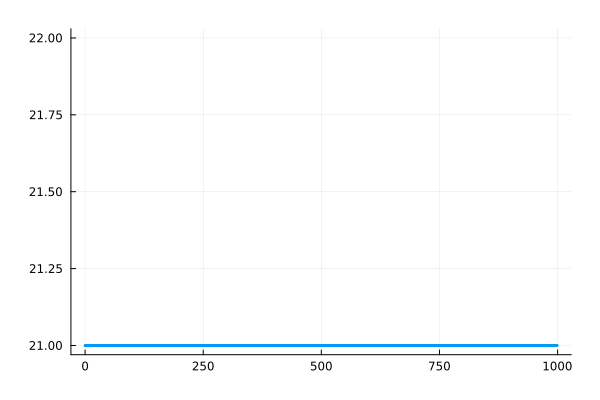

In [46]:
function T_a(t::Float64, t_on::Float64, t_off::Float64)
    return 21 - 5 ./(1+exp(-0.04*(t - t_on))) * exp(-0.05*(t - t_off))./(1+exp(-0.05*(t - t_off)))
end

function T_a(t::Float64)
    return true_τ_a
end

plot(tsteps, T_a.(tsteps))

In [47]:
# # Temperature inputs
# τr = range(0., stop=100, step=0.1)
# NN = length(τr)

# # Generate targets
# r(z,τ_a) = (τ_a - z)^3 ./ 100
# targets = r.(τr, true_τ_a) 

# # Fit GP and optimize kernel hyperparameters
# gp = GPE(τr, targets, MeanZero(), Mat12Iso(1.,0.1))
# results = optimize!(gp, domean=false, kern=true, kernbounds=[(0., 0.), (6., 4.)], noise=false, method=LBFGS())

# l_true = exp(results.minimizer[1])
# γ_true = exp(results.minimizer[2])
# λ_true = sqrt(3)/l_true

# # Kernel
# κ(τ,τ_prime) = γ_true^2 .*exp.(-λ_true.*abs.(τ - τ_prime))
# K = zeros(NN,NN)
# for ii in 1:NN
#     for jj in 1:NN
#         K[ii,jj] = κ(τr[ii], τr[jj])
#     end
# end

# # Inverse of kernel
# Ki = inv(K + 0.0diagm(ones(NN)))

# # GP Predictive distribution
# pred_mean(τ) = dot(κ.(τ,τr), Ki*targets)

# [l_true γ_true]

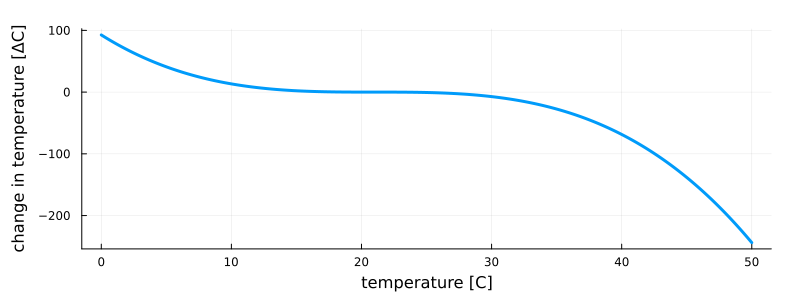

In [48]:
# Nonlinear convection function
r(z,τ_a) = (τ_a - z)^3 ./ 100

τr = range(0., stop=50, step=0.1)
dτr = r.(τr,true_τ_a)

plot(xlabel="temperature [C]", ylabel="change in temperature [ΔC]", size=(800,300))
plot!(τr, dτr)

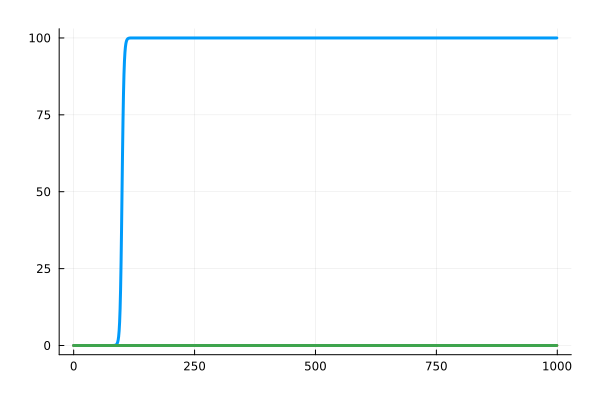

In [49]:
t_onset = 100.
t_offset = 300.
β = 0.5

# Generate functions
u1(t) = u.(t, true_b[1], t_onset, i=1, β=β)
u2(t) = u.(t, true_b[2], t_onset, i=2, β=β)
u3(t) = u.(t, true_b[3], t_onset, i=3, β=β)
  
inputs = hcat([[u1(k); u2(k); u3(k)] for k in tsteps]...)

plot(tsteps, inputs')

In [50]:
function NONLCONV(dz, z, params, t)
    "Lumped-element model with nonlinear convection term"

    # Extract parameters
    mcp_1, mcp_2, mcp_3, a_1, a_2, a_3, k12, k23, h_a = params
    
    # Conduction
    dz[1] = (-k12*z[1] +      k12 *z[2]            ) / mcp_1
    dz[2] = ( k12*z[1] - (k12+k23)*z[2] + k23 *z[3]) / mcp_2
    dz[3] = (                 k23 *z[2] - k23 *z[3]) / mcp_3
    
    # Convection - linear
    dz[1] += h_a * a_1 * (T_a(t) - z[1]) / mcp_1
    dz[2] += h_a * a_2 * (T_a(t) - z[2]) / mcp_2
    dz[3] += h_a * a_3 * (T_a(t) - z[3]) / mcp_3 
    
    # Convection - nonlinear
    dz[1] += r(z[1],T_a(t)) / mcp_1
    dz[2] += r(z[2],T_a(t)) / mcp_2
    dz[3] += r(z[3],T_a(t)) / mcp_3
    
    # Input heat
    dz[1] += u1(t) / mcp_1
    dz[2] += u2(t) / mcp_2
    dz[3] += u3(t) / mcp_3
end

NONLCONV (generic function with 1 method)

In [51]:
sysparams = [true_mcp_1, 
             true_mcp_2, 
             true_mcp_3, 
             true_a_1, 
             true_a_2, 
             true_a_3,
             true_k12, 
             true_k23, 
             true_h_a]

τ_0 = [21., 21., 21.]

# Solve the system numerically using DifferentialEquations.jl
sys_NONLCONV = ODEProblem(NONLCONV, τ_0, (tsteps[1], tsteps[end]), sysparams)
states = Array(solve(sys_NONLCONV, RK4(); saveat=tsteps, verbose = true))

3×1000 Matrix{Float64}:
 21.0  21.0  21.0  21.0  21.0  21.0  …  34.718   34.7187  34.7195  34.7202
 21.0  21.0  21.0  21.0  21.0  21.0     30.1194  30.1203  30.1212  30.1221
 21.0  21.0  21.0  21.0  21.0  21.0     28.196   28.1972  28.1983  28.1994

In [52]:
# Noisy measurements
measurements = zeros(3,T)
for k = 1:T
    measurements[:,k] = states[:,k] + cholesky(true_R).L*randn(3)
end

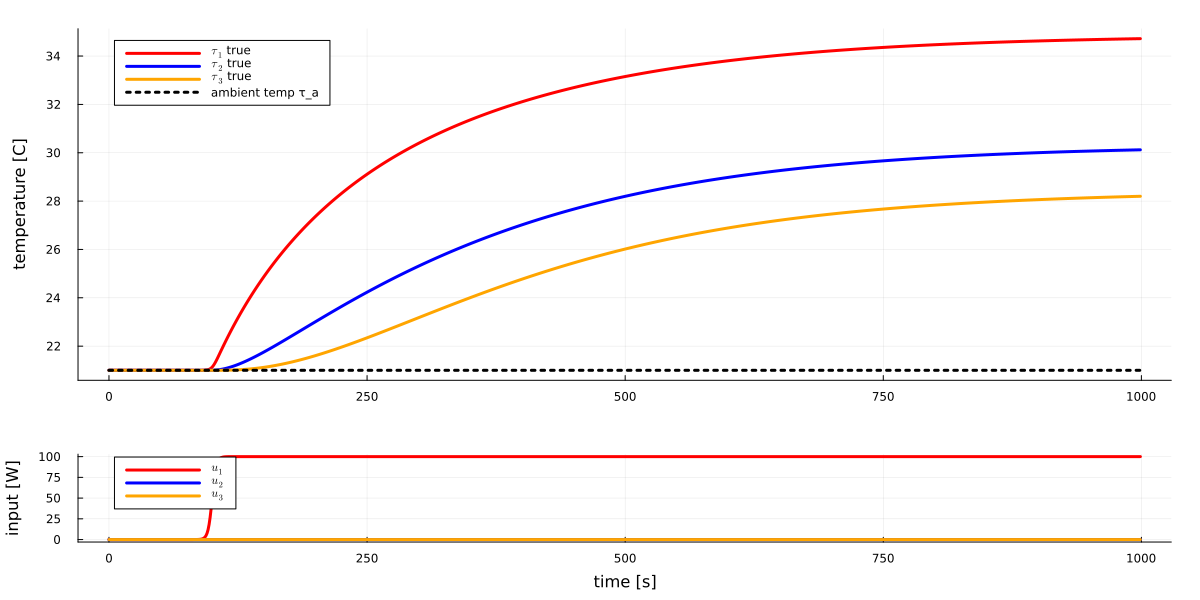

In [53]:
p101 = plot(xlabel="", ylabel="temperature [C]")
plot!(tsteps, states', linecolors = ["red" "blue" "orange"], labels = [L"$τ_1$ true" L"$τ_2$ true" L"$τ_3$ true"], )
# scatter!(tsteps, measurements', markercolors = ["red" "blue" "orange"], labels = [L"$τ_1$ observed" L"$τ_2$ observed" L"$τ_3$ observed"])
plot!(tsteps, T_a.(tsteps), color="black", linewidth=3, linestyle=:dot, label="ambient temp τ_a")

p102 = plot(xlabel = "time [s]", ylabel = "input [W]")
plot!(tsteps, inputs', linecolors = ["red" "blue" "orange"], labels = [L"$u_1$" L"$u_2$" L"$u_3$"], )

plot(p101, p102, layout=grid(2,1, heights=[0.8, 0.2]), size=(1200,600))

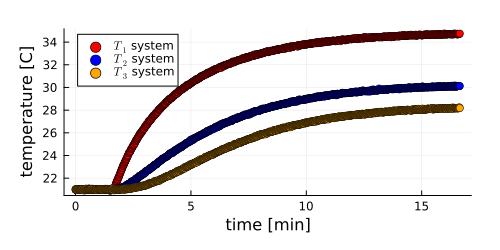

In [54]:
plot(tsteps ./ 60,
     states';
     legend = true, 
     linewidth=4,
    #  title = "GPSSM Simulation MSE = $SMSE_GPSSM",
     linecolors = ["red" "blue" "orange"], 
     fillcolors = ["red" "blue" "orange"], 
#      labels = [L"$T_1$ identified" L"$T_2$ identified" L"$T_3$ identified"],
     xlabel = "time [min]", 
     ylabel = "temperature [C]",
     size=(500,250)
)
scatter!(tsteps ./ 60, 
      transpose(measurements), 
      linewidth=4,
      alpha = 1.,
      markercolors = ["red" "blue" "orange"], 
      linestyle = :dash,
      labels = [L"$T_1$ system" L"$T_2$ system" L"$T_3$ system"],
)


In [55]:
output_ = [measurements[:,k] for k in 1:T];
inputs_ = [[true_τ_a; inputs[:,k]] for k in 1:T];

## GP-augmented state-space model

### Matern-1/2 GP in state-space form
Suppose a function $h(x)$ follows a zero-mean Gaussian Process

$$\begin{aligned}
h(x) \sim \mathcal{GP}(0, k(x,x')) \, .
\end{aligned}$$

The GP can be written as the following differential equation ([Hartikainen, 2013)](https://aaltodoc.aalto.fi/bitstream/handle/123456789/7579/isbn9789526049847.pdf?sequence=1&isAllowed=y)):

$$\begin{align}
\dot{h} = F_h h + L v \, ,
\end{align}$$

with $h$ being states, $F_h$ a state transition matrix and $v$ a white noise process. The Matern GP has a stationary covariance function, defined as:

$$\begin{aligned}
k(\tau) = \sigma^2 \frac{2^{1-\nu}}{\Gamma(\nu)} \left(\frac{\sqrt{2\nu}\tau}{l} \right)^\nu K_\nu\left(\frac{\sqrt{2\nu}\tau}{l} \right)
\end{aligned}$$

where $\sigma^2$ is a scale hyperparameter, $l$ a characteristic length-scale, $\nu$ the smoothness hyperparameter, and $K_\nu(.)$ is a modified Bessel function of the second kind. 

Matern-1/2 refers to $\nu=1/2$. The matrices for the state space model are computed as follows:

$$\begin{aligned}
\mathbf{F}_h = -\lambda,\quad \quad \mathbf{L} = 1, \quad \quad \mathbf{P}_\infty = \sigma^2  ,\quad \quad  Q_c = 2\lambda\sigma^2
\end{aligned}$$ 

where $\lambda = \frac{\sqrt{3}}{l} $.

### Augmented state-space model

The original state-space model (see top) is:

$$\begin{aligned}
\underbrace{\begin{bmatrix} \dot{\tau}_1 \\ \vdots \\ \dot{\tau}_3 \end{bmatrix}}_{\dot{z}} = \underbrace{\begin{bmatrix} \frac{-k_{12} - h_a a_1}{m_1 c_{p,1}} & \frac{k_{12}}{m_1 c_{p,1}} & 0 \\
\frac{k_{12}}{m_2 c_{p,2}} & \frac{-k_{12} - k_{23} - h_a a_2}{m_2 c_{p,2}} & \frac{k_{23}}{m_2 c_{p,2}} \\
 0 & \frac{k_{23}}{m_3 c_{p,3}} & \frac{-k_{23} - h_a a_3}{m_3 c_{p,3}} \end{bmatrix}}_{F} \underbrace{\begin{bmatrix} \tau_1 \\ \vdots \\ \tau_3 \end{bmatrix}}_{z} + \underbrace{\begin{bmatrix} \frac{h_a a_1}{m_1 c_{p,1}} & \frac{1}{m_1 c_{p,1}} & 0 & 0 \\ \frac{h_a a_2}{m_2 c_{p,2}} & 0 & \frac{1}{m_2 c_{p,2}} & 0 \\ \frac{h_a a_3}{m_3 c_{p,3}} & 0 & 0 & \frac{1}{m_3 c_{p,3}} \end{bmatrix}}_{G} \underbrace{\begin{bmatrix} \tau_a \\ u_1 \\ u_2 \\ u_3 \end{bmatrix}}_{u} + M^{-1}r(z) \, 
\end{aligned}$$

Since $r(z)$ is vector-valued, we need multiple GP functions:

$$\begin{aligned}
r(z) \approx h = \begin{bmatrix} h^{(1)} \\ h^{(2)} \\ h^{(3)} \end{bmatrix} \, .
\end{aligned}$$

Augmenting the state-space model with $h$ as described above, gives:

$$\begin{aligned}
\begin{bmatrix} \dot{z} \\ \dot{h} \end{bmatrix} = \begin{bmatrix} F & M^{-1} \\ 0 & F_h \end{bmatrix} \begin{bmatrix} z \\ h \end{bmatrix} +  \begin{bmatrix} G \\ 0 \end{bmatrix} u + \begin{bmatrix} 0 \\ L \end{bmatrix} w \, .
\end{aligned}$$

After discretization, we get:

$$\begin{aligned}
x_{k+1} = A x_k + B u_k + w_k\, , \quad \text{with}\ w_k \sim \mathcal{N}(0, Q) \, ,
\end{aligned}$$

where $x_k = \begin{bmatrix} z_k \\ h_k \end{bmatrix}$ and

$$\begin{aligned}
    A = \exp\big(\Delta t \begin{bmatrix} F & M^{-1} \\ 0 & F_h \end{bmatrix} \big) \, , \quad B = \begin{bmatrix} \Delta t G \\ 0 \end{bmatrix} \, , \quad Q = \int_0^{\Delta t} \exp(\begin{bmatrix} F & M^{-1} \\ 0 & F_h \end{bmatrix}t) \begin{bmatrix} 0 \\ L \end{bmatrix} Q_c \begin{bmatrix} 0 \\ L \end{bmatrix}^{\top} \exp(\begin{bmatrix} F & M^{-1} \\ 0 & F_h \end{bmatrix} t)^{\top} dt \, .
\end{aligned}$$

In [56]:
@model function SSM(A, B, C, Q, R, m0, S0; T=1)
    
    x = randomvar(T)
    u = datavar(Vector{Float64}, T)
    y = datavar(Vector{Float64}, T)
    
    x_0 ~ MvNormalMeanCovariance(m0, S0)
    x_kmin1 = x_0
    for k = 1:T
        
        x[k] ~ MvNormalMeanCovariance(A*x_kmin1 + B*u[k], Q)
        y[k] ~ MvNormalMeanCovariance(C*x[k], R)
        
        x_kmin1 = x[k]
    end
end

In [57]:
Dx = 6
Dt = 3
Dh = 3
Du = 4
Dy = 3

M  = [true_mcp_1          0           0;
     0           true_mcp_2           0;
     0                    0  true_mcp_3]
K  = [-true_k12       true_k12                0;
       true_k12  -(true_k12+true_k23)  true_k23;
              0       true_k23        -true_k23]
An = [true_a_1, true_a_2, true_a_3]

F  = inv(M)*(K - true_h_a*diagm(An))
G  = inv(M)*[true_h_a*An diagm(ones(Dh))]

λ_star = 1.0
γ_star = 1.0

A  = exp([F                              inv(M);
          zeros(Dh,Dh)  diagm(-λ_star*ones(Dh))]*Δt)
B  = [G; zeros(Dh,Du)]*Δt
C  = [diagm(ones(Dy)) zeros(Dy,Dx-Dy)]
Q  = analyticQ(inv(M), λ_star, γ_star, Δt=Δt)
R  = true_R*diagm(ones(Dy))

m0 = [τ_0; zeros(Dh)]
S0 = diagm([ones(Dy); γ_star^2*ones(Dh)])

results = inference(
    model       = SSM(A, B, C, Q, R, m0, S0, T=T),
    data        = (y = output_, u = inputs_),
    options     = (limit_stack_depth = 100,),
    free_energy = true,
)

Inference results:
  Posteriors       | available for (x_0, x)
  Free Energy:     | Real[-5184.29]


In [58]:
# Kernel hyperparameter priors
α_l = 5.
β_l = 0.1
α_γ = 5.
β_γ = 0.1

prior_l = GammaShapeRate(α_l, β_l)
prior_γ = GammaShapeRate(α_γ, β_γ)

[mode(GammaShapeRate(α_l, β_l)) mean(GammaShapeRate(α_l, β_l))  var(GammaShapeRate(α_l, β_l))]

1×3 Matrix{Float64}:
 40.0  50.0  500.0

In [72]:
function J(hparams::AbstractVector)

    λ = sqrt(3)/hparams[1]
    A = [inv(M)*(K-true_h_a*diagm(An))              inv(M);
         zeros(Dh,Dh)                   -λ*diagm(ones(Dh))]*Δt + diagm(ones(Dx))
        
    Q = analyticQ(inv(M), λ, hparams[2], Δt=Δt)
        
    m0 = [τ_0; zeros(3)]
    S0 = diagm([1e-3ones(3); hparams[2]^2*ones(3)])

    results = inference(
        model       = SSM(A, B, C, Q, R, m0, S0, T=T),
        data        = (y = output_, u = inputs_),
        options     = (limit_stack_depth = 100,),
        free_energy = true,
    )

    return results.free_energy[end] - logpdf(prior_l, hparams[1]) -logpdf(prior_γ, hparams[2])
end

ops = Optim.Options(f_tol=1e-3, g_tol=1e-3, time_limit=60, show_every=1)
res = optimize(J, 1e0, 1e6, [10., 10.], Fminbox(LBFGS()), ops; autodiff=:forward)

 * Status: success

 * Candidate solution
    Final objective value:     -5.775850e+03

 * Found with
    Algorithm:     Fminbox with L-BFGS

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 1.0e-03
    |g(x)|                 = 5.27e-04 ≤ 1.0e-03

 * Work counters
    Seconds run:   41  (vs limit 60)
    Iterations:    12
    f(x) calls:    102
    ∇f(x) calls:   102


In [73]:
l_star, γ_star = Optim.minimizer(res)

2-element Vector{Float64}:
 614.6555538167092
   3.2242084777882223

In [105]:
l_star = 1423.21
γ_star = 20.345

20.345

In [106]:
λ_star = sqrt(3)/l_star
A = exp([inv(M)*(K - true_h_a*diagm(An))                  inv(M);
         zeros(Dh,Dh)                  -λ_star*diagm(ones(Dh))]*Δt)
Q = analyticQ(inv(M), λ_star, γ_star, Δt=Δt)

m0 = [τ_0; zeros(Dh)]
S0 = diagm([ones(Dt); γ_star^2*ones(Dh)])

results = inference(
        model       = SSM(A, B, C, Q, R, m0, S0, T=T),
        data        = (y = output_, u = inputs_),
        options     = (limit_stack_depth = 100,),
        free_energy = true,
    )

Inference results:
  Posteriors       | available for (x_0, x)
  Free Energy:     | Real[-5548.51]


In [107]:
H = ForwardDiff.jacobian(x -> ForwardDiff.gradient(J, x), [l_star, γ_star])
post_S = inv(Hermitian((H + H')/2))

2×2 Hermitian{Float64, Matrix{Float64}}:
 -2048.02   -165.246
  -165.246    -3.37817

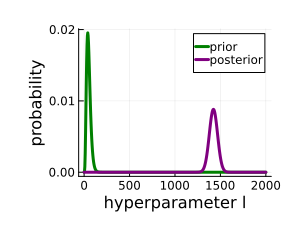

In [127]:
lr = range(1e-3, stop=2e3, length=500)
post_l = NormalMeanVariance(l_star, abs(post_S[1,1]))

p401 = plot(legend=:topright, ylabel="probability", xlabel="hyperparameter l", size=(300,240), yticks=[0., 0.01, 0.02])
plot!(lr, pdf.(prior_l, lr), color="green", label="prior")
# plot!([mode(prior_l), mode(prior_l)], [0.0, pdf(prior_l, mode(prior_l))], linestyle=:dot, color="green")
plot!(lr, pdf.(post_l, lr), color="purple", label="posterior")
# plot!([mode(post_l), mode(post_l)], [0.0, pdf(post_l, mode(post_l))], linestyle=:dot, color="purple")
# vline!([l_true], color="black", linestyle=:dot, label=L"system $l_*$", )

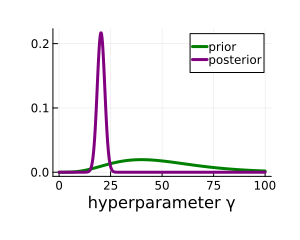

In [133]:
γr = range(1e-2, stop=1e2, length=500)
post_γ = NormalMeanVariance(γ_star, abs(post_S[2,2]))

p402 = plot(legend=:topright, ylabel="", xlabel="hyperparameter γ", size=(300,240), yticks=[0., 0.1, 0.2])
plot!(γr, pdf.(prior_γ, γr), color="green", label="prior")
# plot!([mode(prior_γ), mode(prior_γ)], [0.0, pdf(prior_γ, mode(prior_γ))], linestyle=:dot, color="green")
plot!(γr, pdf.(post_γ, γr), color="purple", label="posterior")
# plot!([mode(post_γ), mode(post_γ)], [0.0, pdf(post_γ, mode(post_γ))], linestyle=:dot, color="purple")
# vline!([l_true], color="black", linestyle=:dot, label=L"system $l_*$", )

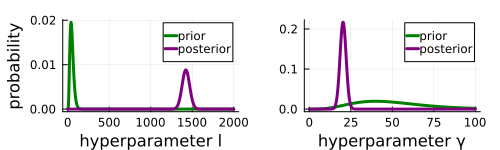

In [146]:
plot(p401,p402, layout=(1,2), size=(500,150), margin=3.0Plots.mm)

In [147]:
savefig("figures/hparams-estimated.png")

"/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/sioux/sysid-thermal/CCTA2024-BIDconvection/experiment-simulated/figures/hparams-estimated.png"

In [89]:
qx = results.posteriors[:x]
fitx_v = cat( var.(qx)..., dims=2)
fitx_m = cat(mean.(qx)..., dims=2)

6×1000 Matrix{Float64}:
 21.0216   21.0131    21.0136    …   34.7069    34.7207    34.7445
 20.9672   20.964     20.9646        30.1283    30.1174    30.1276
 21.0187   20.9982    21.0061        28.2217    28.225     28.1921
 -1.00768  -0.998722  -0.982231     -24.5988   -24.4897   -24.4284
  1.11976   1.12976    1.14989       -6.65525   -6.6407    -6.61996
 -1.03954  -1.01266   -0.970769  …   -3.92112   -4.01181   -4.05703

In [90]:
SMSE_GPSSM = mean((fitx_m[1:3,:] - states).^2)
println("MSE states and fit: $SMSE_GPSSM")

MSE states and fit: 0.00045037298001026856


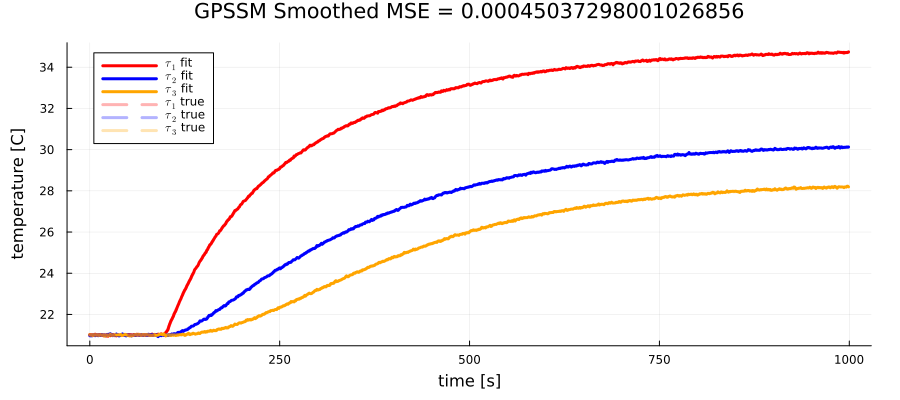

In [91]:
plot(tsteps,
     fitx_m[1:3,:]';
     ribbon=sqrt.(fitx_v[1:3,:])',
     legend = true, 
     title="GPSSM Smoothed MSE = $SMSE_GPSSM",
     linecolors = ["red" "blue" "orange"], 
     fillcolors = ["red" "blue" "orange"], 
     labels = [L"$τ_1$ fit" L"$τ_2$ fit" L"$τ_3$ fit"],
     xlabel = "time [s]", 
     ylabel = "temperature [C]",
     size=(900,400)
)
plot!(tsteps, 
      transpose(states), 
      alpha = 0.3,
      linecolors = ["red" "blue" "orange"], 
      linestyle = :dash,
      labels = [L"$τ_1$ true" L"$τ_2$ true" L"$τ_3$ true"],
)


### Gaussian process fits over time

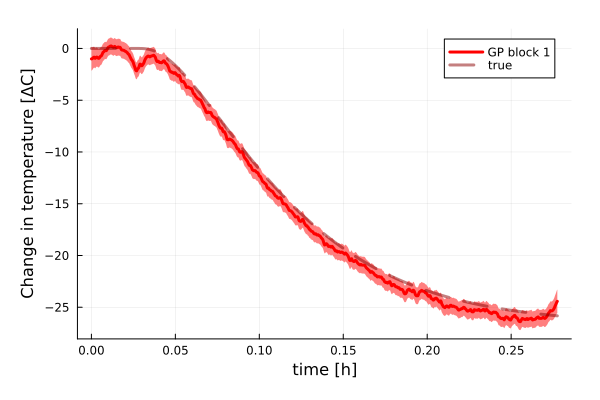

In [92]:
plot(tsteps ./ 3600,
     fitx_m[4,:];
     ribbon=sqrt.(fitx_v[4,:])./10,
     legend = true, 
     color = "red",
     labels = "GP block 1",
     xlabel = "time [h]", 
     ylabel = "Change in temperature [ΔC]",
     size=(600,400)
)
plot!(tsteps ./ 3600, r.(states[1,:], true_τ_a), color="darkred", alpha=0.5, linestyle=:dash, label="true")
# plot!(tsteps, r.(states[1,:],1,true_τ_a), color="darkred", alpha=0.5, linestyle=:dash, label="true")

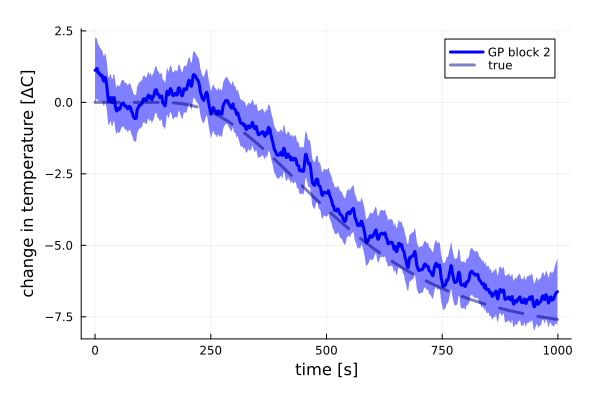

In [93]:
plot(tsteps,
     fitx_m[5,:],
     ribbon=sqrt.(fitx_v[5,:])./10,
     legend = true, 
     color = "blue",
     labels = "GP block 2",
     xlabel = "time [s]", 
     ylabel = "change in temperature [ΔC]",
     size=(600,400)
)
plot!(tsteps, r.(states[2,:], true_τ_a), color="darkblue", alpha=0.5, linestyle=:dash, label="true")

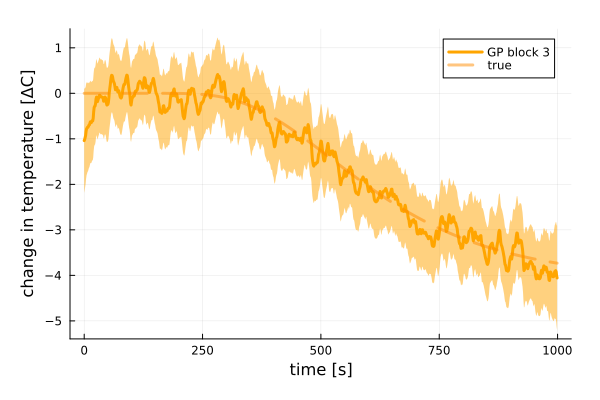

In [94]:
plot(tsteps,
     fitx_m[6,:],
     ribbon=sqrt.(fitx_v[6,:]) ./ 10,
     legend = true, 
     color = "orange",
     labels = "GP block 3",
     xlabel = "time [s]", 
     ylabel = "change in temperature [ΔC]",
     size=(600,400)
)
plot!(tsteps, r.(states[3,:], true_τ_a), color="darkorange", alpha=0.5, linestyle=:dash, label="true")

### Extract nonlinearity

In [95]:
n_samples = 5
deg = 3

yls = [-0.5, 0.05]
xls = [285, 296]

samples_z1 = cat([rand(Normal(fitx_m[1,k],sqrt.(fitx_v[1,k])), n_samples) for k in 1:T]...,dims=2)
samples_z2 = cat([rand(Normal(fitx_m[2,k],sqrt.(fitx_v[2,k])), n_samples) for k in 1:T]...,dims=2)
samples_z3 = cat([rand(Normal(fitx_m[3,k],sqrt.(fitx_v[3,k])), n_samples) for k in 1:T]...,dims=2)
samples_f1 = cat([rand(Normal(fitx_m[4,k],sqrt.(fitx_v[4,k])), n_samples) for k in 1:T]...,dims=2)
samples_f2 = cat([rand(Normal(fitx_m[5,k],sqrt.(fitx_v[5,k])), n_samples) for k in 1:T]...,dims=2)
samples_f3 = cat([rand(Normal(fitx_m[6,k],sqrt.(fitx_v[6,k])), n_samples) for k in 1:T]...,dims=2)

5×1000 Matrix{Float64}:
  19.8282    11.1494   -27.8038   …  -20.4249     2.72567   -9.05117
   2.9953   -17.1179     4.36573       1.35014   -9.34331  -14.5409
   2.16184    6.37355    1.65866     -19.8621     1.15426   -0.396151
 -26.2214   -12.4051    14.3769       -8.36774  -13.3159   -23.8456
  -1.83048   -2.32237  -10.8324      -16.2637    -5.598     -2.56875

In [96]:
f1_pol3 = Polynomials.fit(Polynomial{Float64}, fitx_m[1,:], fitx_m[4,:], deg, weights=fitx_v[4,:])

Polynomial(88.1408003285188 - 12.719384400974729*x + 0.607829435259071*x^2 - 0.009690582987929203*x^3)

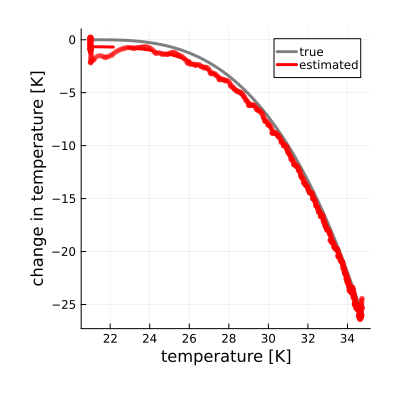

In [97]:
plot(xlabel="temperature [K]",
     ylabel="change in temperature [K]",
     # yticks=(range(-1000,stop=0.0, length=5), round.(range(-1000,stop=0.0, length=5).*Δt./true_mcp_1, digits=2)),
     # ylims=(-1000,0)
     size=(400,400),
     )
plot!(states[1,:], r.(states[1,:],true_τ_a), color="black", alpha=0.5, label="true")
# scatter!(fitx_m[1,:], samples_f1', alpha=0.05, markerstrokewidth=0, markersize=3, color="red")
scatter!(fitx_m[1,:], fitx_m[4,:], alpha=0.5, markerstrokewidth=0, markersize=3, color="red")
plot!(sort(fitx_m[1,:]), x -> f1_pol3(x), color="red", linestyle=:dash, label="estimated")

In [33]:
f2_pol3 = Polynomials.fit(fitx_m[2,:], fitx_m[5,:], deg, weights=fitx_v[5,:])

Polynomial(46.580750712730215 - 7.9002455280134*x + 0.4258211634172155*x^2 - 0.007386422110508573*x^3)

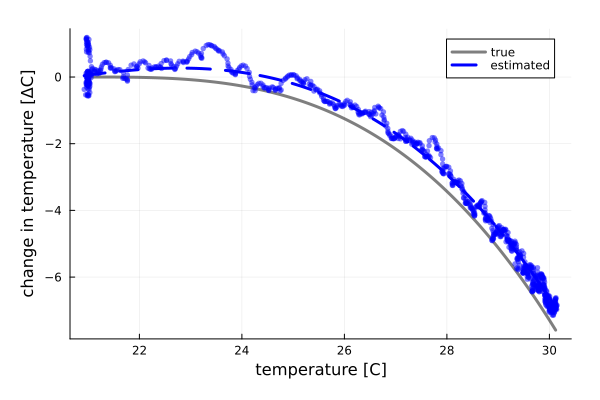

In [98]:
plot(xlabel="temperature [C]",
     ylabel="change in temperature [ΔC]",
     # yticks=(range(-250,stop=50., length=4), round.(range(-250,stop=50., length=4).*Δt./true_mcp_2, digits=2)),
     # ylims=(-250,50),
     )
plot!(states[2,:], r.(states[2,:],true_τ_a), color="black", alpha=0.5, label="true")
# scatter!(fitx_m[2,:], samples_f2', alpha=0.05, markerstrokewidth=0, markersize=3, color="blue")
scatter!(fitx_m[2,:], fitx_m[5,:], alpha=0.5, markerstrokewidth=0, markersize=3, color="blue")
plot!(fitx_m[2,:], x -> f2_pol3(x), color="blue", linestyle=:dash, label="estimated")

In [35]:
f3_pol3 = Polynomials.fit(fitx_m[3,:], fitx_m[6,:], deg, weights=fitx_v[6,:])

Polynomial(87.06697266242593 - 12.597861937695457*x + 0.6056435777532899*x^2 - 0.009685527470224466*x^3)

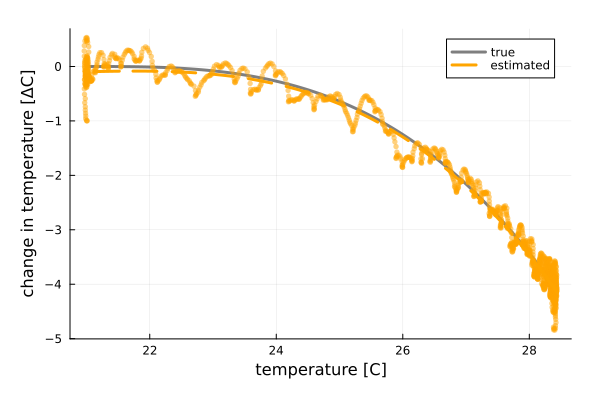

In [36]:
plot(xlabel="temperature [C]",
     ylabel="change in temperature [ΔC]",
     # yticks=(range(-60,stop=0., length=4), round.(range(-60,stop=0, length=4).*Δt./true_mcp_3, digits=2)),
     # ylims=(-60, 0.),
     )
plot!(states[3,:], r.(states[3,:],true_τ_a), color="black", alpha=0.5, label="true")
# scatter!(fitx_m[3,:], samples_f3', alpha=0.05, markerstrokewidth=0, markersize=3, color="orange")
scatter!(fitx_m[3,:], fitx_m[6,:], alpha=0.5, markerstrokewidth=0, markersize=3, color="orange")
plot!(fitx_m[3,:], x -> f3_pol3(x), color="orange", linestyle=:dash, label="estimated")

## Model validation

### Simulation with true function to generate validation data

In [148]:
N_val = 1000
tsteps_val = range(0.0, step=Δt, length=N_val)

t_onset_val = 120.
t_offset_val = 600.
β = 0.5

# Generate functions
# u1(t) = u.(t, b=true_b[1], t_on=t_onset, t_off=t_offset, i=1, β1=β)
u1_val(t) = u.(t, b=true_b[1], t_on=t_onset_val, t_off=t_offset_val, i=1, β1=β)
u2_val(t) = u.(t, b=true_b[2], t_on=t_onset_val, t_off=t_offset_val, i=2, β1=β)
u3_val(t) = u.(t, b=true_b[3], t_on=t_onset_val, t_off=t_offset_val, i=3, β1=β)

inputs_val = hcat([[u1_val(k); u2_val(k); u3_val(k)] for k in tsteps_val]...)

3×1000 Matrix{Float64}:
 8.75651e-25  1.4437e-24  2.38027e-24  3.9244e-24  …  7.24967e-68  4.8596e-68
 0.0          0.0         0.0          0.0            0.0          0.0
 0.0          0.0         0.0          0.0            0.0          0.0

In [149]:
function NONLCONV_val(dz, z, params, t)
    "Lumped-element model with nonlinear convection term"

    # Extract parameters
    mcp_1, mcp_2, mcp_3, a_1, a_2, a_3, τ_a, k12, k23, h_a = params
    
    # Conduction
    dz[1] = (-k12*z[1] +      k12 *z[2]            ) / mcp_1
    dz[2] = ( k12*z[1] - (k12+k23)*z[2] + k23 *z[3]) / mcp_2
    dz[3] = (                 k23 *z[2] - k23 *z[3]) / mcp_3
    
    # Convection - linear
    dz[1] += h_a * a_1 * (τ_a - z[1]) / mcp_1
    dz[2] += h_a * a_2 * (τ_a - z[2]) / mcp_2
    dz[3] += h_a * a_3 * (τ_a - z[3]) / mcp_3
    
    # Convection - nonlinear
    dz[1] += r(z[1],τ_a) ./ mcp_1
    dz[2] += r(z[2],τ_a) ./ mcp_2
    dz[3] += r(z[3],τ_a) ./ mcp_3
    
    # Input heat
    dz[1] += u1_val(t) / mcp_1
    dz[2] += u2_val(t) / mcp_2
    dz[3] += u3_val(t) / mcp_3
end

NONLCONV_val (generic function with 1 method)

In [150]:
sysparams = [true_mcp_1, 
             true_mcp_2, 
             true_mcp_3, 
             true_a_1, 
             true_a_2, 
             true_a_3, 
             true_τ_a, 
             true_k12, 
             true_k23, 
             true_h_a]

τ0_val = [25., 25., 25.]
sys_NONLCONV = ODEProblem(NONLCONV_val, τ0_val, (tsteps_val[1], tsteps_val[end]), sysparams)
states_val = Array(solve(sys_NONLCONV, RK4(); saveat=tsteps_val, verbose = true))

measurements_val = states_val + cholesky(true_R).L*randn(size(states_val))

3×1000 Matrix{Float64}:
 24.9905  25.0254  25.0194  24.9935  …  24.6507  24.664   24.6416  24.5917
 24.9547  24.9856  24.9367  24.9488     24.6235  24.5997  24.5922  24.6103
 25.0268  25.014   24.9839  24.9515     24.6013  24.5851  24.584   24.5854

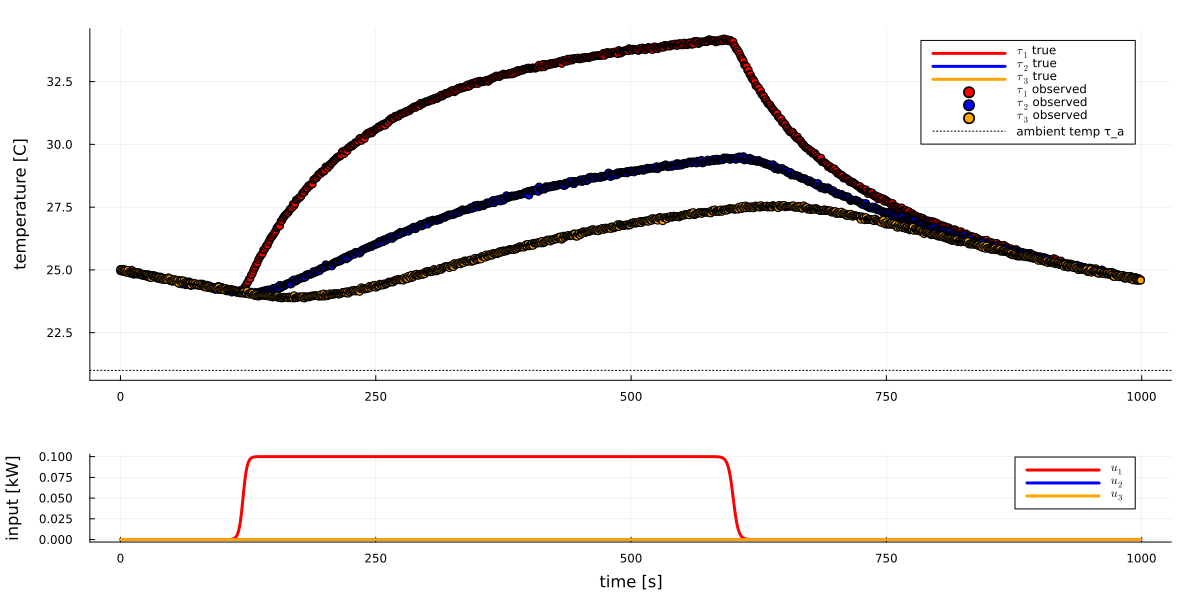

In [151]:
p101 = plot(xlabel="", ylabel="temperature [C]")
plot!(tsteps_val, states_val', linecolors = ["red" "blue" "orange"], labels = [L"$τ_1$ true" L"$τ_2$ true" L"$τ_3$ true"], )
scatter!(tsteps_val, measurements_val', markercolors = ["red" "blue" "orange"], labels = [L"$τ_1$ observed" L"$τ_2$ observed" L"$τ_3$ observed"])
hline!([true_τ_a], color="black", linewidth=1, linestyle=:dot, label="ambient temp τ_a")

p102 = plot(xlabel = "time [s]", ylabel = "input [kW]")
plot!(tsteps_val, inputs_val' ./ 1000, linecolors = ["red" "blue" "orange"], labels = [L"$u_1$" L"$u_2$" L"$u_3$"], )

plot(p101, p102, layout=grid(2,1, heights=[0.8, 0.2]), size=(1200,600))

### Simulation by identified model

In [152]:
function NONLCONV_idsim(dz, z, params, t)
    "Lumped-element model with nonlinear convection term"

    # Extract parameters
    mcp_1, mcp_2, mcp_3, a_1, a_2, a_3, τ_a, k12, k23, h_a = params
    
    # Conduction
    dz[1] = (-k12*z[1] +      k12 *z[2]            ) / mcp_1
    dz[2] = ( k12*z[1] - (k12+k23)*z[2] + k23 *z[3]) / mcp_2
    dz[3] = (                 k23 *z[2] - k23 *z[3]) / mcp_3
    
    # Convection - linear
    dz[1] += h_a * a_1 * (τ_a - z[1]) / mcp_1
    dz[2] += h_a * a_2 * (τ_a - z[2]) / mcp_2
    dz[3] += h_a * a_3 * (τ_a - z[3]) / mcp_3
    
    # Convection - nonlinear
    dz[1] += f1_pol3(z[1]) ./ mcp_1
    dz[2] += f2_pol3(z[2]) ./ mcp_2
    dz[3] += f3_pol3(z[3]) ./ mcp_3
    
    # Input heat
    dz[1] += u1_val(t) / mcp_1
    dz[2] += u2_val(t) / mcp_2
    dz[3] += u3_val(t) / mcp_3
end

idNONLCONV = ODEProblem(NONLCONV_idsim, τ0_val, (tsteps_val[1], tsteps_val[end]), sysparams)
sim_states = Array(solve(idNONLCONV, Tsit5(); saveat=tsteps_val, verbose = true))

3×1000 Matrix{Float64}:
 25.0  24.9907  24.9813  24.9721  …  24.5822  24.5742  24.5662  24.5583
 25.0  24.9918  24.9836  24.9754     24.6156  24.6079  24.6001  24.5924
 25.0  24.9913  24.9827  24.9741     24.5985  24.591   24.5835  24.576

### Compare true and identified 

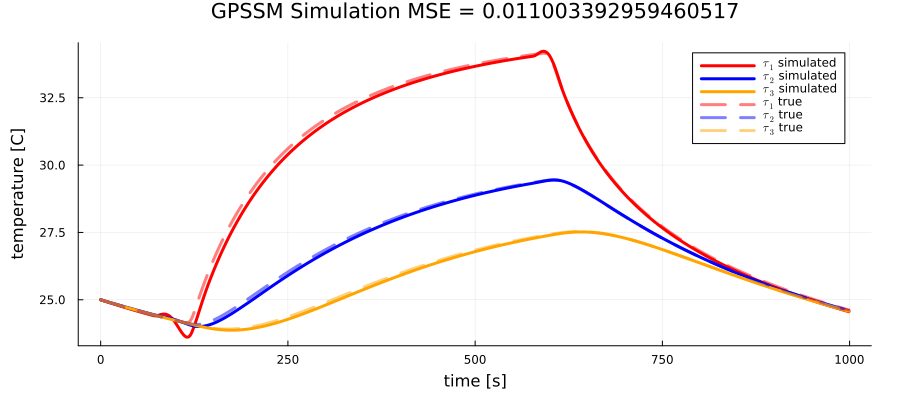

In [153]:
SMSE_GPSSM = mean((sim_states - states_val).^2)

plot(tsteps_val,
     sim_states';
     legend = true, 
     title = "GPSSM Simulation MSE = $SMSE_GPSSM",
     linecolors = ["red" "blue" "orange"], 
     fillcolors = ["red" "blue" "orange"], 
     labels = [L"$τ_1$ simulated" L"$τ_2$ simulated" L"$τ_3$ simulated"],
     xlabel = "time [s]", 
     ylabel = "temperature [C]",
     size=(900,400)
)
plot!(tsteps_val, 
      transpose(states_val), 
      alpha = 0.5,
      linecolors = ["red" "blue" "orange"], 
      linestyle = :dash,
      labels = [L"$τ_1$ true" L"$τ_2$ true" L"$τ_3$ true"],
)


In [154]:
jldsave("results/LGPASSM.jld2"; true_mcp_1, true_mcp_2, true_mcp_3, true_τ_a, tsteps, Δt, fitx_m, fitx_v, states, measurements, inputs, f1_pol3, f2_pol3, f3_pol3, l_star, γ_star, tsteps_val, sim_states, states_val)